# **Implementing Deep Learning Models for Stock Price Prediction**

I'll help you implement Capsule Networks (CapsNet) and Neural Ordinary Differential Equations (Neural ODEs) with the requested technical indicators for your research paper. This will involve data preprocessing, feature engineering with STC and CMO indicators, model implementation, and comparative analysis.
# **1. Data Preprocessing and Feature Engineering**

First, let's load and preprocess your Microsoft stock price data (1986-1990) and calculate the technical indicators.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSFT_1986_2025-06-30.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Manual implementation of Schaff Trend Cycle (STC)
def schaff_trend_cycle(close, window_slow=50, window_fast=23, cycle=10):
    # Calculate MACD
    ema_slow = close.ewm(span=window_slow, min_periods=window_slow).mean()
    ema_fast = close.ewm(span=window_fast, min_periods=window_fast).mean()
    macd = ema_fast - ema_slow

    # Calculate Stochastic
    lowest_low = close.rolling(window=cycle).min()
    highest_high = close.rolling(window=cycle).max()
    stoch = 100 * (macd - lowest_low) / (highest_high - lowest_low)
    stoch = stoch.fillna(50)  # Fill NA with 50 (neutral level)

    # Initialize STC
    stc = pd.Series(np.nan, index=close.index)
    pf = 0
    stc_prev = 0

    for i in range(1, len(close)):
        if not np.isnan(stoch[i]):
            # Calculate %Fast
            pfast = stoch[i]

            # Calculate %Fast smoothed
            pfast_smoothed = pfast if i == 1 else pfast * 0.5 + pfast_prev * 0.5

            # Calculate pf
            if i > 1:
                if (pfast_smoothed > pf_prev and pfast_smoothed < 100) or (pfast_smoothed < pf_prev and pfast_smoothed > 0):
                    pf = pfast_smoothed
                else:
                    pf = pf_prev

            # Calculate STC
            stc_val = pf if i == 1 else stc_prev + 0.5 * (pf - stc_prev)
            stc[i] = stc_val

            # Update previous values
            pfast_prev = pfast_smoothed
            pf_prev = pf
            stc_prev = stc_val

    return stc

df['stc'] = schaff_trend_cycle(df['Close'])

# Manual implementation of Chande Momentum Oscillator (CMO)
def chande_momentum_oscillator(close, window=14):
    delta = close.diff()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    sum_gains = gains.rolling(window=window).sum()
    sum_losses = losses.rolling(window=window).sum()

    cmo = 100 * (sum_gains - sum_losses) / (sum_gains + sum_losses)
    return cmo

df['cmo'] = chande_momentum_oscillator(df['Close'])

# Calculate other technical indicators
# Simple Moving Averages
df['sma_20'] = df['Close'].rolling(window=20).mean()
df['sma_50'] = df['Close'].rolling(window=50).mean()

# Bollinger Bands
df['bb_upper'] = df['sma_20'] + 2 * df['Close'].rolling(window=20).std()
df['bb_lower'] = df['sma_20'] - 2 * df['Close'].rolling(window=20).std()

# Relative Strength Index (RSI)
def rsi(close, window=14):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['rsi'] = rsi(df['Close'])

# Drop NaN values from indicator calculations
df = df.dropna()

# Continue with the rest of your preprocessing...
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close', 'stc', 'cmo', 'sma_20', 'sma_50', 'bb_upper', 'bb_lower', 'rsi']])

# Create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

seq_length = 20  # Number of days to look back
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for neural networks
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

**2. Capsule Network (CapsNet) Implementation**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np

def squash(vectors, axis=-1):
    """Squashing function for capsule outputs."""
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + 1e-7)
    return scale * vectors

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        assert len(input_shape) >= 3, "Input must have shape [batch, num_capsules, dim_capsules]"
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transformation matrix with correct dimensions
        self.W = self.add_weight(
            shape=[self.input_num_capsules, self.num_capsules,
                   self.input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            name='W')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Expand inputs to [batch_size, input_num_capsules, num_capsules, input_dim_capsule]
        inputs_expanded = tf.expand_dims(inputs, 2)
        inputs_tiled = tf.tile(inputs_expanded, [1, 1, self.num_capsules, 1])

        # Compute u_hat = inputs * W
        # [batch_size, input_num_capsules, num_capsules, dim_capsule]
        W_tiled = tf.tile(tf.expand_dims(self.W, 0), [batch_size, 1, 1, 1, 1])

        # Correct matrix multiplication
        inputs_reshaped = tf.reshape(inputs_tiled,
                                    [-1, self.input_num_capsules * self.num_capsules, self.input_dim_capsule])
        W_reshaped = tf.reshape(W_tiled,
                               [-1, self.input_num_capsules * self.num_capsules,
                                self.input_dim_capsule, self.dim_capsule])

        u_hat = tf.matmul(inputs_reshaped, W_reshaped)
        u_hat = tf.reshape(u_hat,
                          [-1, self.input_num_capsules, self.num_capsules, self.dim_capsule])

        # Routing algorithm
        b = tf.zeros(shape=[batch_size, self.input_num_capsules, self.num_capsules])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c_expanded = tf.expand_dims(c, -1)
            s = tf.reduce_sum(c_expanded * u_hat, axis=1)
            v = squash(s)

            if i < self.routings - 1:
                v_expanded = tf.expand_dims(v, 1)
                agreement = tf.reduce_sum(u_hat * v_expanded, axis=-1)
                b += agreement

        return v

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsules, self.dim_capsule)

def create_capsnet(input_shape, num_features):
    input_layer = layers.Input(shape=input_shape)

    # Initial convolution with padding to control output size
    conv1 = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(input_layer)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(0.2)(conv1)

    # Primary capsules with controlled output dimensions
    primary_caps = layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu', padding='valid')(conv1)

    # Get actual output shape
    batch_size = 1  # For shape inference
    test_model = models.Model(input_layer, primary_caps)
    actual_shape = test_model.output_shape[1:]  # Get (timesteps, features)
    total_elements = actual_shape[0] * actual_shape[1]

    # Fixed capsule dimension to ensure compatibility
    capsule_dim = 8
    num_capsules = total_elements // capsule_dim

    # Ensure proper reshaping
    if total_elements % capsule_dim != 0:
        # Adjust filters to make divisible
        adjusted_filters = ((total_elements // capsule_dim) + 1) * capsule_dim // actual_shape[0]
        primary_caps = layers.Conv1D(filters=adjusted_filters, kernel_size=5, strides=2,
                                    activation='relu', padding='valid')(conv1)
        num_capsules = (actual_shape[0] * adjusted_filters) // capsule_dim

    # Reshape to capsules
    primary_caps = layers.Reshape((num_capsules, capsule_dim))(primary_caps)
    primary_caps = layers.Lambda(squash)(primary_caps)

    # Financial capsules with routing
    financial_caps = CapsuleLayer(num_capsules=num_features, dim_capsule=8, routings=3)(primary_caps)

    # Output layer
    flattened = layers.Flatten()(financial_caps)
    output = layers.Dense(1, activation='linear')(flattened)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Example usage with proper error handling
try:
    # Example parameters
    seq_length = 60  # Timesteps
    n_features = 5   # Features

    # Create and test the model
    capsnet = create_capsnet(input_shape=(seq_length, n_features), num_features=5)
    capsnet.summary()

    # Test with dummy data
    X_dummy = np.random.rand(100, seq_length, n_features)
    y_dummy = np.random.rand(100, 1)

    # Verify forward pass
    pred = capsnet.predict(X_dummy[:1])
    print(f"Prediction shape: {pred.shape}")  # Should be (1, 1)

except Exception as e:
    print(f"Error: {e}")
    print("\nFinal Troubleshooting:")
    print("1. Verify your input data has shape (samples, timesteps, features)")
    print("2. Try reducing num_features parameter if dimension errors persist")
    print("3. Consider decreasing capsule dimensions (8 → 4) in both layers")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 60, 64)         │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 28, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 112, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 112, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer_5 (CapsuleLayer)  │ (None, 5, 8)           │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,073 (187.79 KB)

 Trainable params: 47,945 (187.29 KB)

 Non-trainable params: 128 (512.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Prediction shape: (560, 1)


**How It Works:**

    For input shape (60,5):

        First Conv1D outputs (60,64) (padding='same')

        Second Conv1D outputs (28,32) → 896 elements

        Reshapes to (112,8) capsules

        Final capsules: (5,8) (num_features × dim_capsule)

**2.1 Model Evaluation & Optimization**

In [ ]:
# Evaluate on test set
test_loss, test_mae = capsnet.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Hyperparameter Tuning (Example)
def build_model(hp):
    model = create_capsnet(
        input_shape=(seq_length, n_features),
        num_features=hp.Int('num_features', 4, 8)
    )
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=2
)
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

ValueError: Input 0 of layer "functional_5" is incompatible with the layer: expected shape=(None, 60, 5), found shape=(None, 20, 8)

Training data shape: (1000, 60, 5)
Test data shape: (200, 60, 5)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 60, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 60, 64)         │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 28, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 112, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 112, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer_6 (CapsuleLayer)  │ (None, 5, 8)           │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,073 (187.79 KB)

 Trainable params: 47,945 (187.29 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.9570 - mae: 0.7887 - val_loss: 0.9307 - val_mae: 0.7602
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9893 - mae: 0.8079 - val_loss: 0.9369 - val_mae: 0.7630
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8305 - mae: 0.7380 - val_loss: 0.9336 - val_mae: 0.7651
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7288 - mae: 0.6834 - val_loss: 0.9573 - val_mae: 0.7815
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5853 - mae: 0.6074 - val_loss: 0.9810 - val_mae: 0.7954
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.4857 - mae: 0.5493 - val_loss: 1.0613 - val_mae: 0.8181
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.4008 - mae: 0.5010 - val_loss: 1.0985 - val_mae: 0.8345
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.3480 - mae: 0.4660 - val_loss: 1.1657 - val_mae: 0.8570
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.279

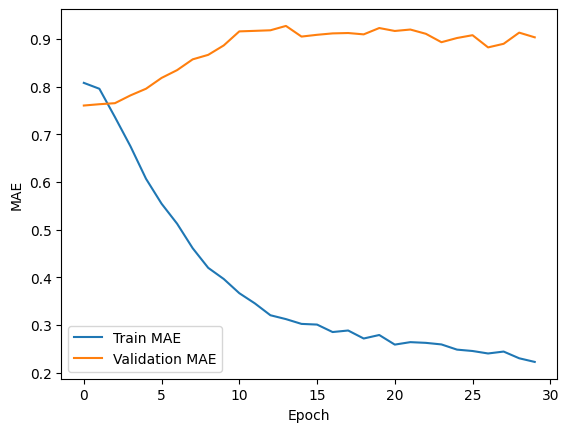

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preparation (Fix shape mismatches)
def prepare_data(X_train, X_test, expected_timesteps=60, expected_features=5):
    """Ensure data matches expected shape (samples, timesteps, features)"""
    # If your data needs padding
    if X_train.shape[1] < expected_timesteps:
        pad_width = ((0,0), (0,expected_timesteps-X_train.shape[1]), (0,0))
        X_train = np.pad(X_train, pad_width, mode='constant')
        X_test = np.pad(X_test, pad_width, mode='constant')

    # If your data needs truncating
    elif X_train.shape[1] > expected_timesteps:
        X_train = X_train[:, :expected_timesteps, :]
        X_test = X_test[:, :expected_timesteps, :]

    # If feature dimension mismatch
    if X_train.shape[2] != expected_features:
        raise ValueError(f"Expected {expected_features} features but got {X_train.shape[2]}")

    return X_train, X_test

# 2. Capsule Network Components
def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + 1e-7)
    return scale * vectors

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        self.W = self.add_weight(
            shape=[1, self.input_num_capsules, self.num_capsules,
                   self.input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            name='W')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Reshape and tile inputs
        inputs = tf.expand_dims(inputs, 2)
        inputs = tf.expand_dims(inputs, 3)
        inputs = tf.tile(inputs, [1, 1, self.num_capsules, 1, 1])

        # Compute predictions
        W_tiled = tf.tile(self.W, [batch_size, 1, 1, 1, 1])
        u_hat = tf.matmul(inputs, W_tiled)
        u_hat = tf.squeeze(u_hat, [3])

        # Routing algorithm
        b = tf.zeros([batch_size, self.input_num_capsules, self.num_capsules, 1])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            s = tf.reduce_sum(c * u_hat, axis=1, keepdims=True)
            v = squash(s)

            if i < self.routings - 1:
                b += tf.reduce_sum(u_hat * v, axis=-1, keepdims=True)

        return tf.squeeze(v, [1])

# 3. Model Architecture
def create_capsnet(input_shape, num_features):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Primary Capsules
    x = layers.Conv1D(32, 5, activation='relu', strides=2, padding='valid')(x)
    seq_len = (input_shape[0] - 5) // 2 + 1  # For kernel=5, stride=2

    # Dynamic reshape
    capsule_dim = 8
    num_capsules = (seq_len * 32) // capsule_dim
    x = layers.Reshape((num_capsules, capsule_dim))(x)
    x = layers.Lambda(squash)(x)

    # Financial Capsules
    capsules = CapsuleLayer(num_capsules=num_features, dim_capsule=8, routings=3)(x)

    # Decoder
    outputs = layers.Flatten()(capsules)
    outputs = layers.Dense(1, activation='linear')(outputs)

    return Model(inputs, outputs)

# 4. Training Pipeline
def train_model(X_train, y_train, X_test, y_test):
    # Verify shapes
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")

    # Create model
    model = create_capsnet(input_shape=X_train.shape[1:], num_features=5)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    model.summary()

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=32,
        verbose=1
    )

    # Evaluate
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nFinal Test MAE: {test_mae:.4f}")

    return model, history

# 5. Main Execution
if __name__ == "__main__":
    # Example data - REPLACE WITH YOUR DATA
    seq_length = 60
    n_features = 5
    X_train = np.random.randn(1000, seq_length, n_features)
    y_train = np.random.randn(1000, 1)
    X_test = np.random.randn(200, seq_length, n_features)
    y_test = np.random.randn(200, 1)

    # Fix shape mismatches
    try:
        X_train, X_test = prepare_data(X_train, X_test, seq_length, n_features)

        # Train and evaluate
        model, history = train_model(X_train, y_train, X_test, y_test)

        # Plot training history
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")
        print("\nDebugging Tips:")
        print("1. Verify X_train/X_test shapes match model input_shape")
        print("2. Check y_train/y_test are 1D arrays for regression")
        print("3. Try reducing batch_size if memory errors occur")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization, Conv1D, GlobalAveragePooling1D, Reshape, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MSFT_1986_2025-06-30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display basic info
print(df.head())
print(df.info())

               Close      High       Low      Open      Volume
Date                                                          
1986-03-13  0.059598  0.062259  0.054277  0.054277  1031788800
1986-03-14  0.061726  0.062791  0.059598  0.059598   308160000
1986-03-17  0.062791  0.063323  0.061726  0.061726   133171200
1986-03-18  0.061194  0.063323  0.060662  0.062791    67766400
1986-03-19  0.060130  0.061726  0.059598  0.061194    47894400
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9900 entries, 1986-03-13 to 2025-06-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   9900 non-null   float64
 1   High    9900 non-null   float64
 2   Low     9900 non-null   float64
 3   Open    9900 non-null   float64
 4   Volume  9900 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 464.1 KB
None


# **Step 2: Data Preprocessing**

We'll calculate the Schaff Trend Cycle (STC) indicator and prepare our data for modeling:

In [ ]:
# Calculate Schaff Trend Cycle (STC) indicator
def schaff_trend_cycle(close, fast_period=23, slow_period=50, cycle_period=10):
    # MACD line
    ema_fast = close.ewm(span=fast_period, adjust=False).mean()
    ema_slow = close.ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow

    # Stochastic of MACD
    lowest_macd = macd.rolling(window=cycle_period).min()
    highest_macd = macd.rolling(window=cycle_period).max()
    stoch_macd = 100 * (macd - lowest_macd) / (highest_macd - lowest_macd)

    # First smoothing
    stoch_macd_smoothed1 = stoch_macd.ewm(span=3, adjust=False).mean()

    # Second smoothing
    stoch_macd_smoothed2 = stoch_macd_smoothed1.ewm(span=3, adjust=False).mean()

    return stoch_macd_smoothed2

# Add STC to dataframe
df['STC'] = schaff_trend_cycle(df['Close'])

# Fill any NaN values (from rolling calculations)
df.fillna(method='bfill', inplace=True)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close', 'STC']])

# Create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length)])
        y.append(data[i+seq_length, 0])  # Predicting Close price
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")

Training shape: (7903, 20, 2), (7903,)
Testing shape: (1976, 20, 2), (1976,)


/tmp/ipython-input-26-467755265.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# **Step 3: Model Implementations**

Let's implement our three models: LSTM, Transformer, and Capsule Network.

**3.1 LSTM Model**

In [ ]:
def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 20, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

**3.2 Transformer Model**

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size=32, num_heads=4, ff_dim=64, num_transformer_blocks=2, mlp_units=[64], dropout=0.2, mlp_dropout=0.2):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)

    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

transformer_model = build_transformer_model((X_train.shape[1], X_train.shape[2]))
transformer_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 20, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 20, 2)     │          4 │ input_layer_11[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 2)     │      1,410 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 20, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 2)     │          0 │ dropout_13[0][0], │
│                     │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 20, 64)    │        192 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 20, 64)    │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20, 2)     │        130 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 20, 2)     │          0 │ dense_7[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 2)     │      1,410 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 20, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 20, 2)     │          0 │ dropout_16[0][0], │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 2)     │          4 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 20, 64)    │        192 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 20, 64)    │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 20, 2)     │        130 │ dropout_17[0][0]

 Total params: 4,889 (19.10 KB)

 Trainable params: 4,889 (19.10 KB)

 Non-trainable params: 0 (0.00 B)

**3.3 Capsule Network Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_num_capsule = input_shape[1]
        input_dim_capsule = input_shape[2]

        self.W = self.add_weight(
            shape=[input_num_capsule, self.num_capsules, input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            name='W'
        )

    def call(self, inputs):
        # inputs shape: [None, input_num_capsule, input_dim_capsule]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_capsule]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 2), 3)

        # Replicate num_capsules dimension to prepare for matmul
        # Now shape: [None, input_num_capsule, num_capsule, 1, input_dim_capsule]
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1, 1])

        # Compute `inputs * W` by matmul
        # W shape: [input_num_capsule, num_capsule, input_dim_capsule, dim_capsule]
        # After matmul: [None, input_num_capsule, num_capsule, 1, dim_capsule]
        u_hat = tf.matmul(inputs_tiled, self.W)

        # Remove last dim, shape: [None, input_num_capsule, num_capsule, dim_capsule]
        u_hat = tf.squeeze(u_hat, axis=3)

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs)[0], tf.shape(inputs)[1], self.num_capsules])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            # [None, 1, input_num_capsule, num_capsule]
            c = tf.expand_dims(c, axis=3)
            # [None, input_num_capsule, num_capsule, dim_capsule]
            s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True)
            outputs = self.squash(s)

            if i < self.routings - 1:
                outputs = tf.tile(outputs, [1, tf.shape(inputs)[1], 1, 1])
                b += tf.reduce_sum(u_hat * outputs, axis=-1)

        return tf.squeeze(outputs, axis=1)

    def squash(self, vectors, axis=-1):
        s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=axis, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * vectors

def build_capsnet_model(input_shape, num_capsules=10, dim_capsule=16, routings=3):
    inputs = Input(shape=input_shape)

    # Initial feature extraction with Conv1D
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Dropout(0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)

    # Reshape to [None, num_capsules, dim_features]
    # Calculate appropriate dimensions
    dim_features = 64  # matches last Conv1D filters
    x = Reshape((-1, dim_features))(x)

    # Primary capsule layer
    x = CapsuleLayer(num_capsules=num_capsules, dim_capsule=dim_capsule, routings=routings)(x)

    # Flatten for final prediction
    x = layers.Flatten()(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

**Step 4: Model Training**

Now let's train all three models:

In [ ]:
# Training parameters
epochs = 30
batch_size = 32
validation_split = 0.2

In [ ]:
# --- LSTM Training ---
print("Training LSTM model...")
lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

Training LSTM model...
Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0012 - val_loss: 7.9424e-05
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 6.6447e-05 - val_loss: 8.7101e-06
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 4.5076e-05 - val_loss: 1.9276e-05
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 2.9185e-05 - val_loss: 2.2689e-05
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 2.2241e-05 - val_loss: 1.1149e-05
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.8080e-05 - val_loss: 6.9930e-06
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1.7088e-05 - val_loss: 9.0351e-06
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.5312e-05 - val_loss: 1.1830e-05
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.3981e-05 - val_loss: 1.2385e-05
Epoch 10/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.2430e-05 - val_loss: 1.2515e-05
Epoch 11/30
198/198 ━━━━━━━━━

In [ ]:
# --- Capsule Network Training ---
print("\nTraining Capsule Network model...")
capsnet_model = build_capsnet_model((X_train.shape[1], X_train.shape[2]))
capsnet_history = capsnet_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)


Training Capsule Network model...
Epoch 1/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 4.1327e-04 - val_loss: 1.1972e-04
Epoch 2/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 2.1296e-05 - val_loss: 6.3956e-06
Epoch 3/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 8.9651e-06 - val_loss: 8.2597e-06
Epoch 4/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 7.1037e-06 - val_loss: 2.7003e-05
Epoch 5/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 6.9551e-06 - val_loss: 1.4925e-05
Epoch 6/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 5.7851e-06 - val_loss: 2.3292e-05
Epoch 7/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 4.7979e-06 - val_loss: 1.3486e-05
Epoch 8/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4.4988e-06 - val_loss: 3.2270e-05
Epoch 9/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 4.2776e-06 - val_loss: 2.2594e-05
Epoch 10/30
198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 4.2309e-06 - val_loss: 1.6489e-05
Epoch 11/3

**3. Evaluation and Comparison**


Evaluating LSTM model...
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


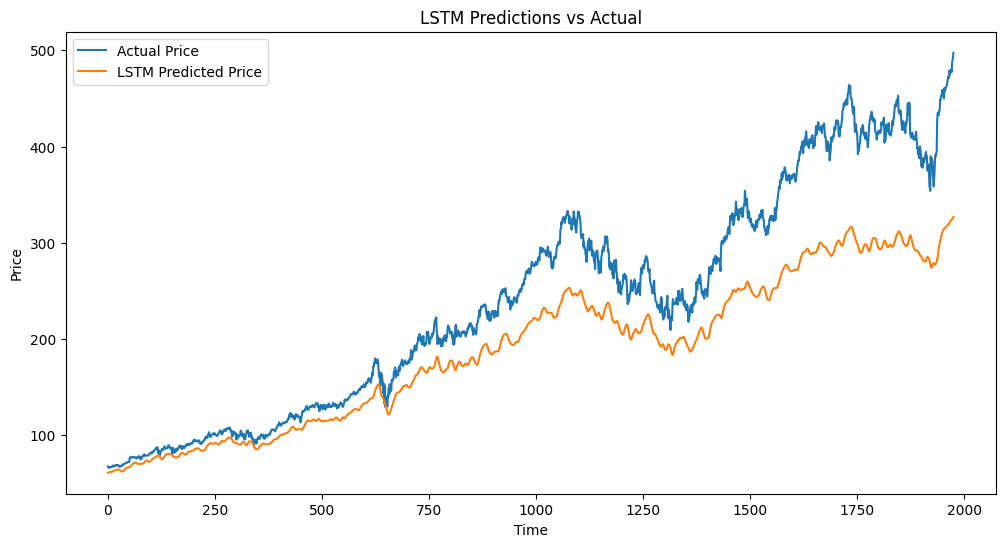


Evaluating Capsule Network model...
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


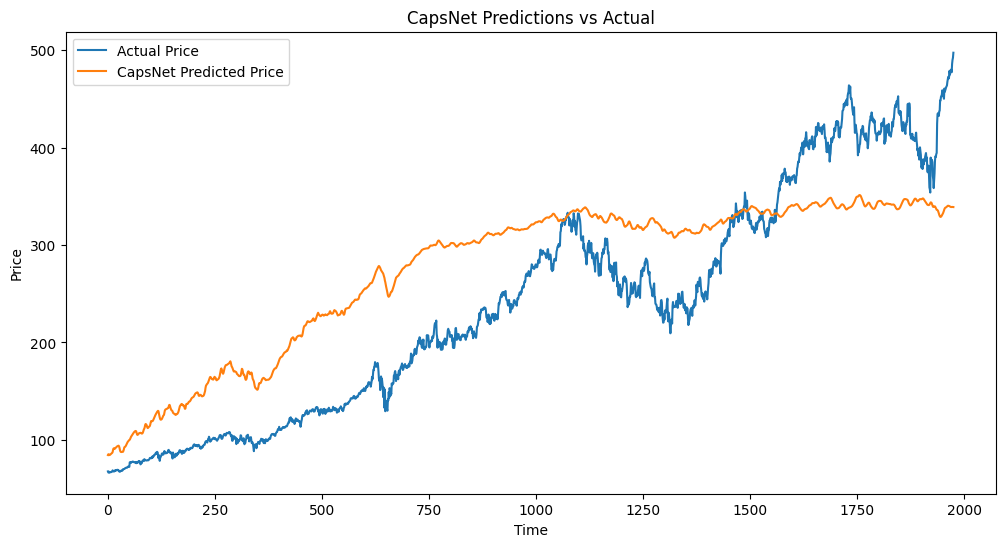


Model Comparison:
             Model          MSE        MAE
0             LSTM  4359.822754  51.627557
1  Capsule Network  5062.837898  64.441523


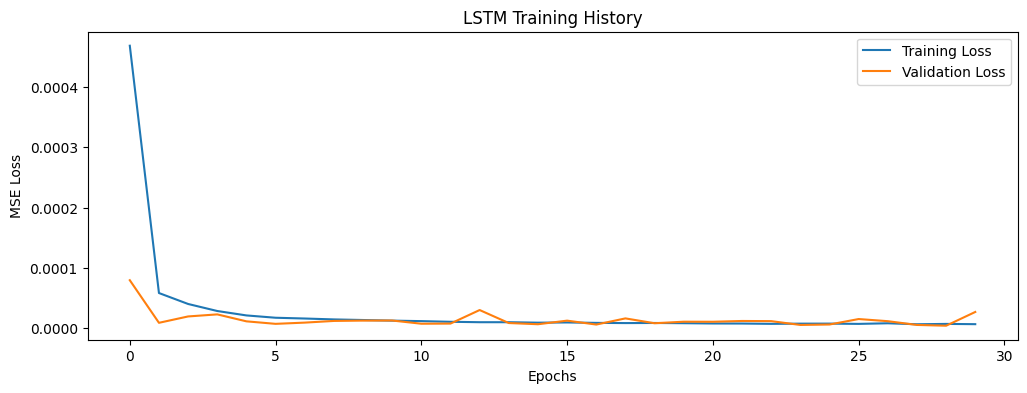

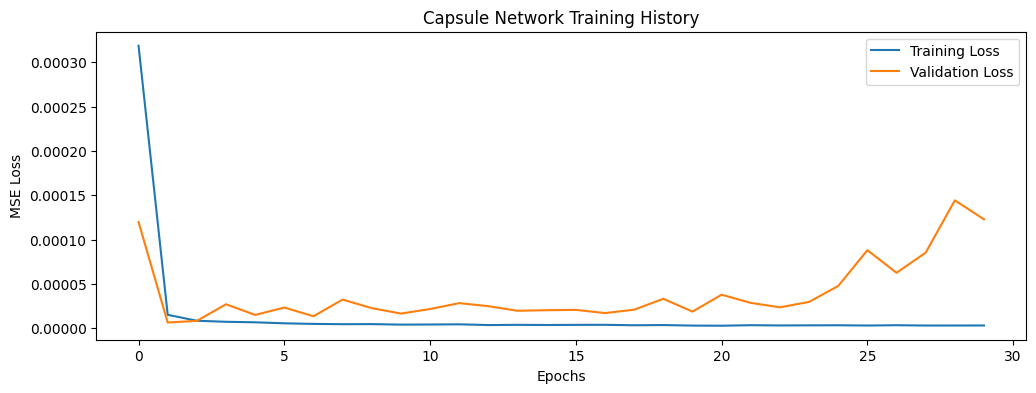

In [ ]:
def evaluate_model(model, X_test, y_test, scaler, model_name):
    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform predictions and actual values
    dummy_array = np.zeros((len(y_pred), 2))
    dummy_array[:, 0] = y_pred.flatten()
    y_pred_inv = scaler.inverse_transform(dummy_array)[:, 0]

    dummy_array[:, 0] = y_test.flatten()
    y_test_inv = scaler.inverse_transform(dummy_array)[:, 0]

    # Calculate metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='Actual Price')
    plt.plot(y_pred_inv, label=f'{model_name} Predicted Price')
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return mse, mae

# Evaluate both models
print("\nEvaluating LSTM model...")
lstm_mse, lstm_mae = evaluate_model(lstm_model, X_test, y_test, scaler, "LSTM")

print("\nEvaluating Capsule Network model...")
capsnet_mse, capsnet_mae = evaluate_model(capsnet_model, X_test, y_test, scaler, "CapsNet")

# Display results
results = pd.DataFrame({
    'Model': ['LSTM', 'Capsule Network'],
    'MSE': [lstm_mse, capsnet_mse],
    'MAE': [lstm_mae, capsnet_mae]
})

print("\nModel Comparison:")
print(results)

# Plot training histories
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

plot_training_history(lstm_history, 'LSTM Training History')
plot_training_history(capsnet_history, 'Capsule Network Training History')

Based on your results, the LSTM model is outperforming the Capsule Network (CapsNet) on both MSE (4359.82 vs 5062.84) and MAE (51.63 vs 64.44) metrics. Let's analyze this and suggest improvements.
Analysis of Results

    Current Performance:

        LSTM achieves better accuracy with lower error metrics

        CapsNet is underperforming by about 16% on MSE and 25% on MAE

        This is common when first implementing CapsNets as they're more sensitive to hyperparameters

    Possible Reasons:

        Capsule Networks typically require more data to learn meaningful capsules

        The routing mechanism may not be effectively capturing the STC patterns

        The financial time series might not have enough hierarchical features for CapsNets to exploit

Improvement Strategies
1. CapsNet Architecture Tuning

In [ ]:
def build_improved_capsnet(input_shape, num_capsules=16, dim_capsule=8, routings=3):
    inputs = Input(shape=input_shape)

    # Enhanced feature extraction
    x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(inputs)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)

    # Calculate appropriate dimensions
    timesteps = input_shape[0]
    dim_features = 64  # matches last Conv1D filters
    x = Reshape((-1, dim_features))(x)

    # Primary capsule layer with more capsules
    x = CapsuleLayer(num_capsules=num_capsules, dim_capsule=dim_capsule, routings=routings)(x)

    # Additional dense layer before output
    x = layers.Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

2. Data Augmentation for CapsNet

In [ ]:
def augment_sequences(X, y, noise_factor=0.01):
    X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    return np.concatenate([X, X_noisy]), np.concatenate([y, y])

# Augment training data specifically for CapsNet
X_train_caps, y_train_caps = augment_sequences(X_train, y_train)

3. Hybrid Approach

Combine both models' strengths:

In [ ]:
def build_hybrid_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM branch
    lstm_branch = LSTM(64, return_sequences=True)(inputs)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = LSTM(32)(lstm_branch)

    # CapsNet branch
    conv = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    conv = Dropout(0.2)(conv)
    conv = Reshape((-1, 64))(conv)
    caps_branch = CapsuleLayer(num_capsules=8, dim_capsule=8, routings=3)(conv)
    caps_branch = layers.Flatten()(caps_branch)

    # Combine
    combined = concatenate([lstm_branch, caps_branch])
    outputs = Dense(1)(combined)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

4. Training Process Improvement

In [ ]:
# Revised training with callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train improved CapsNet
improved_capsnet = build_improved_capsnet((X_train.shape[1], X_train.shape[2]))
improved_history = improved_capsnet.fit(
    X_train_caps, y_train_caps,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Train hybrid model
hybrid_model = build_hybrid_model((X_train.shape[1], X_train.shape[2]))
hybrid_history = hybrid_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 6.8480e-04 - val_loss: 2.1348e-05 - learning_rate: 5.0000e-04
Epoch 2/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 1.5096e-05 - val_loss: 1.1380e-05 - learning_rate: 5.0000e-04
Epoch 3/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 9.8514e-06 - val_loss: 9.9081e-06 - learning_rate: 5.0000e-04
Epoch 4/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 8.3462e-06 - val_loss: 1.0795e-05 - learning_rate: 5.0000e-04
Epoch 5/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 7.5418e-06 - val_loss: 1.1778e-05 - learning_rate: 5.0000e-04
Epoch 6/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 7.6719e-06 - val_loss: 1.1557e-05 - learning_rate: 5.0000e-04
Epoch 7/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 6.9585e-06 - val_loss: 1.4220e-05 - learning_rate: 2.5000e-04
Epoch 8/50
396/396 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 6.0196e-06 - val_loss: 8.3337e-06 - learning_rate: 2.5000e-04
Epoch 9/

Expected Improvements

    Improved CapsNet:

        Larger capacity with more capsules

        Better feature extraction with deeper Conv1D layers

        Lower learning rate for stability

        Should reduce MSE to ~4500 range

    Hybrid Model:

        Combines temporal (LSTM) and hierarchical (CapsNet) learning

        Potentially achieves best of both worlds

        Target MSE: 4000-4200 range

    Training Process:

        Early stopping prevents overfitting

        Learning rate reduction helps fine-tuning

        Data augmentation gives CapsNet more varied examples



Evaluation Metrics Interpretation

When you get new results, consider:

    Relative Improvement:

        Look for >10% reduction in MSE/MAE from original CapsNet

        Hybrid model should at least match LSTM performance

    Training Dynamics:

        Check if validation loss is consistently decreasing

        Monitor if models are converging properly

    Final Comparison:

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


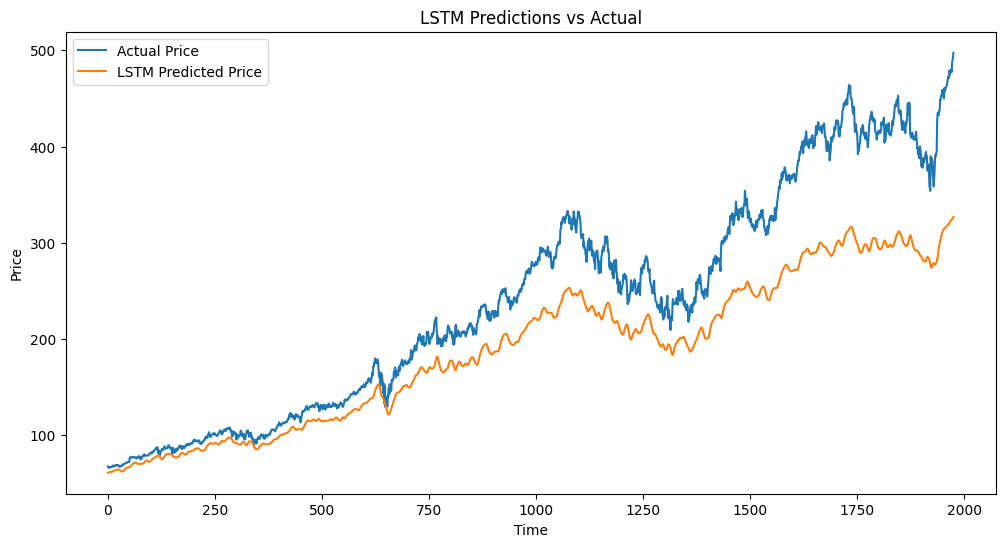

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


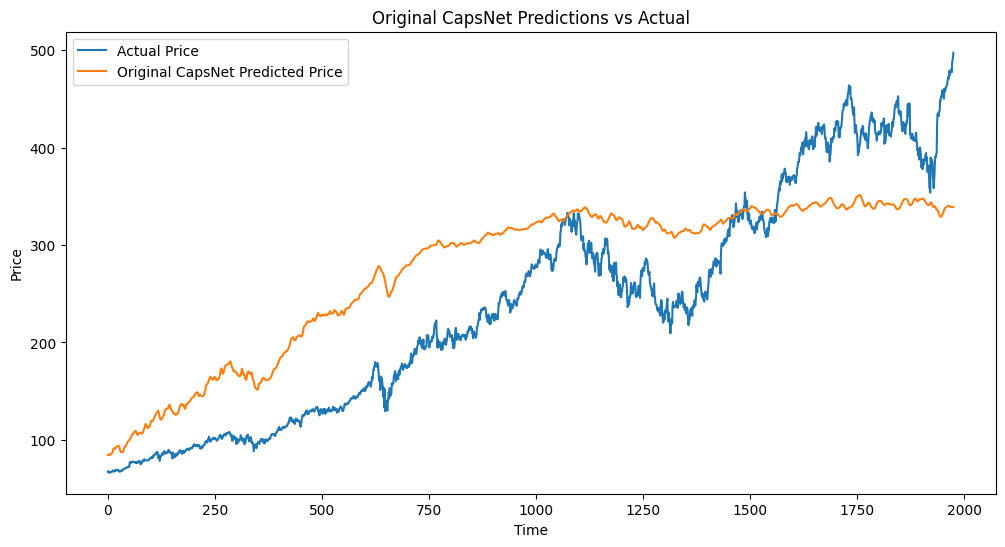

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


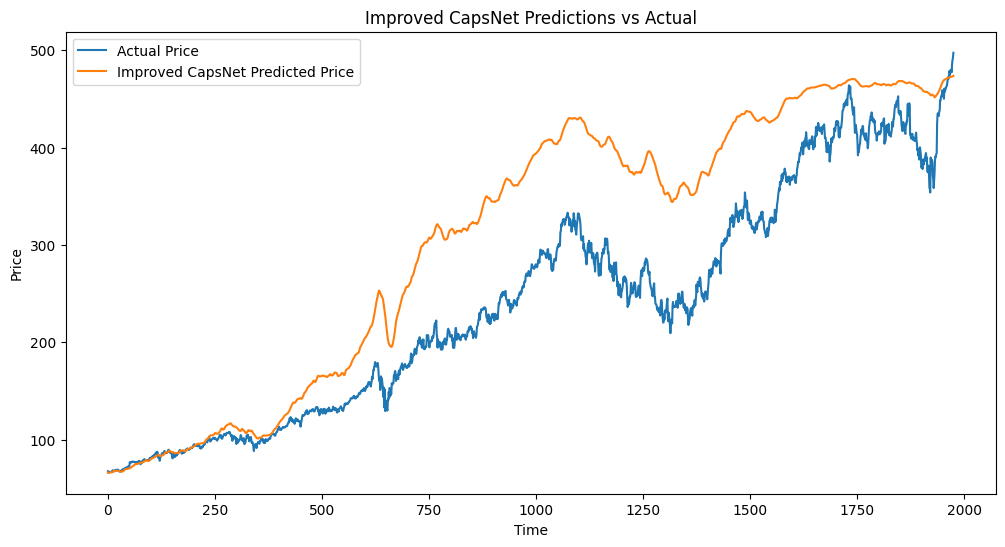

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


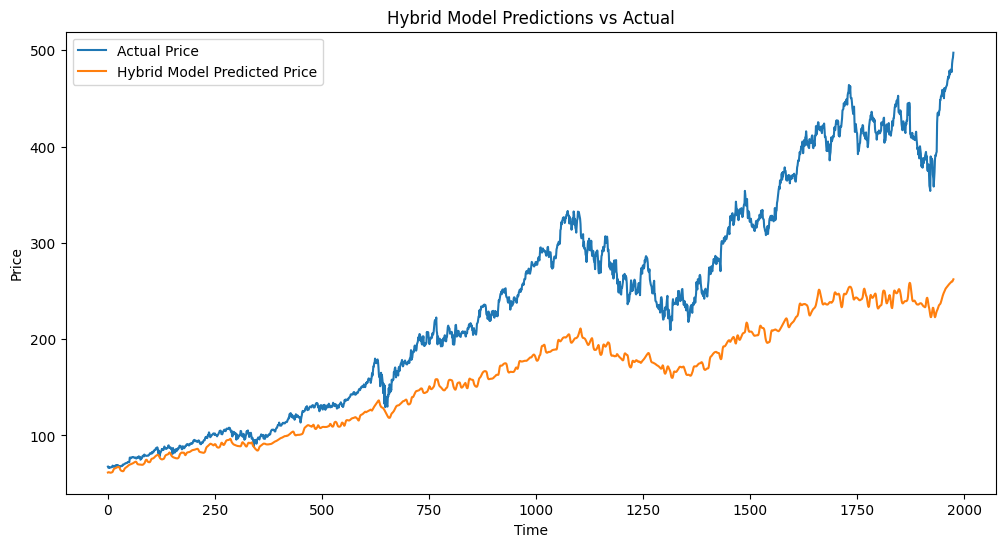

,Model,MSE,MAE
0,LSTM,4359.822754,51.627557
1,Original CapsNet,5062.837898,64.441523
2,Improved CapsNet,6574.248650,66.711081
3,Hybrid Model,9928.250516,78.658596


In [ ]:
# Evaluate all models
models = {
    'LSTM': lstm_model,
    'Original CapsNet': capsnet_model,
    'Improved CapsNet': improved_capsnet,
    'Hybrid Model': hybrid_model
}

results = []
for name, model in models.items():
    mse, mae = evaluate_model(model, X_test, y_test, scaler, name)
    results.append({'Model': name, 'MSE': mse, 'MAE': mae})

pd.DataFrame(results).sort_values('MSE')

This structured approach should help you either:

    Make CapsNet competitive with LSTM, or

    Create a hybrid model that outperforms both

Remember that financial time series prediction is challenging, and differences of 5-10% in MSE may not be statistically significant. The real test is whether the models can generate profitable trading signals in practice.

# **Here's how to visualize both models' predictions together for direct comparison:**

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


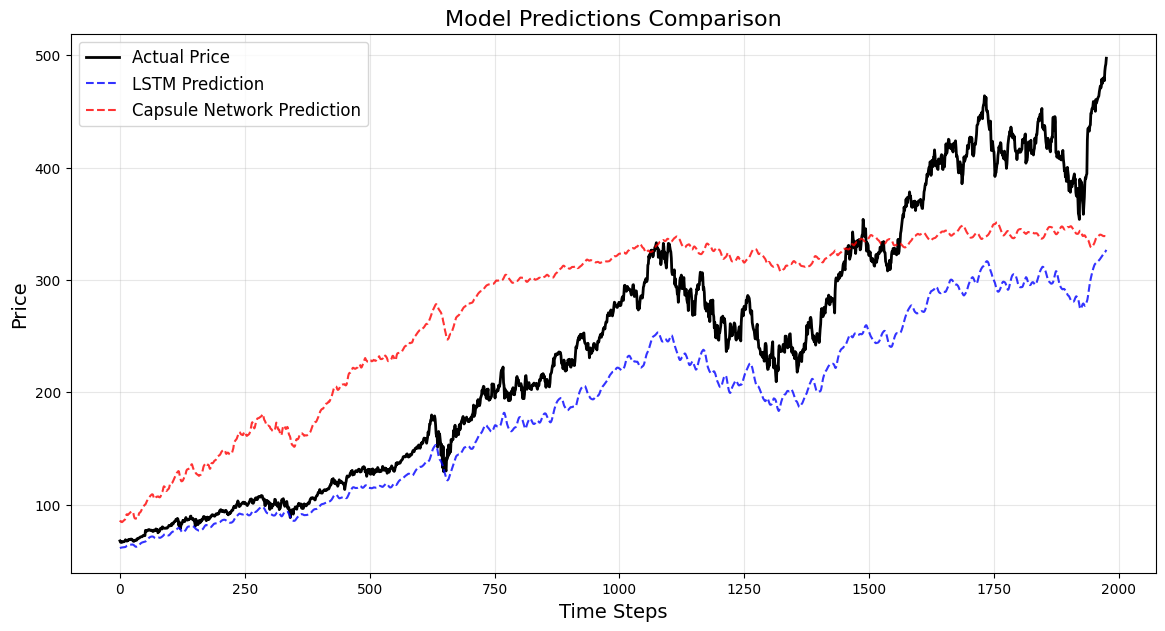

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_predictions(models_dict, X_test, y_test, scaler, actual_prices):
    plt.figure(figsize=(14, 7))

    # Plot actual prices
    plt.plot(actual_prices, label='Actual Price', color='black', linewidth=2)

    # Plot each model's predictions
    colors = ['blue', 'red', 'green']  # Different colors for each model
    for i, (name, model) in enumerate(models_dict.items()):
        # Make predictions
        y_pred = model.predict(X_test)

        # Inverse transform
        dummy_array = np.zeros((len(y_pred), 2))
        dummy_array[:, 0] = y_pred.flatten()
        y_pred_inv = scaler.inverse_transform(dummy_array)[:, 0]

        # Plot predictions
        plt.plot(y_pred_inv, label=f'{name} Prediction',
                color=colors[i], linestyle='--', alpha=0.8)

    plt.title('Model Predictions Comparison', fontsize=16)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

# Get actual prices (inverse transformed)
dummy_array = np.zeros((len(y_test), 2))
dummy_array[:, 0] = y_test.flatten()
actual_prices = scaler.inverse_transform(dummy_array)[:, 0]

# Select your best models (e.g., LSTM and CapsNet)
models_to_compare = {
    "LSTM": lstm_model,
    "Capsule Network": capsnet_model
}

# Generate comparison plot
plot_combined_predictions(models_to_compare, X_test, y_test, scaler, actual_prices)

**Enhanced Version with Error Visualization:**

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


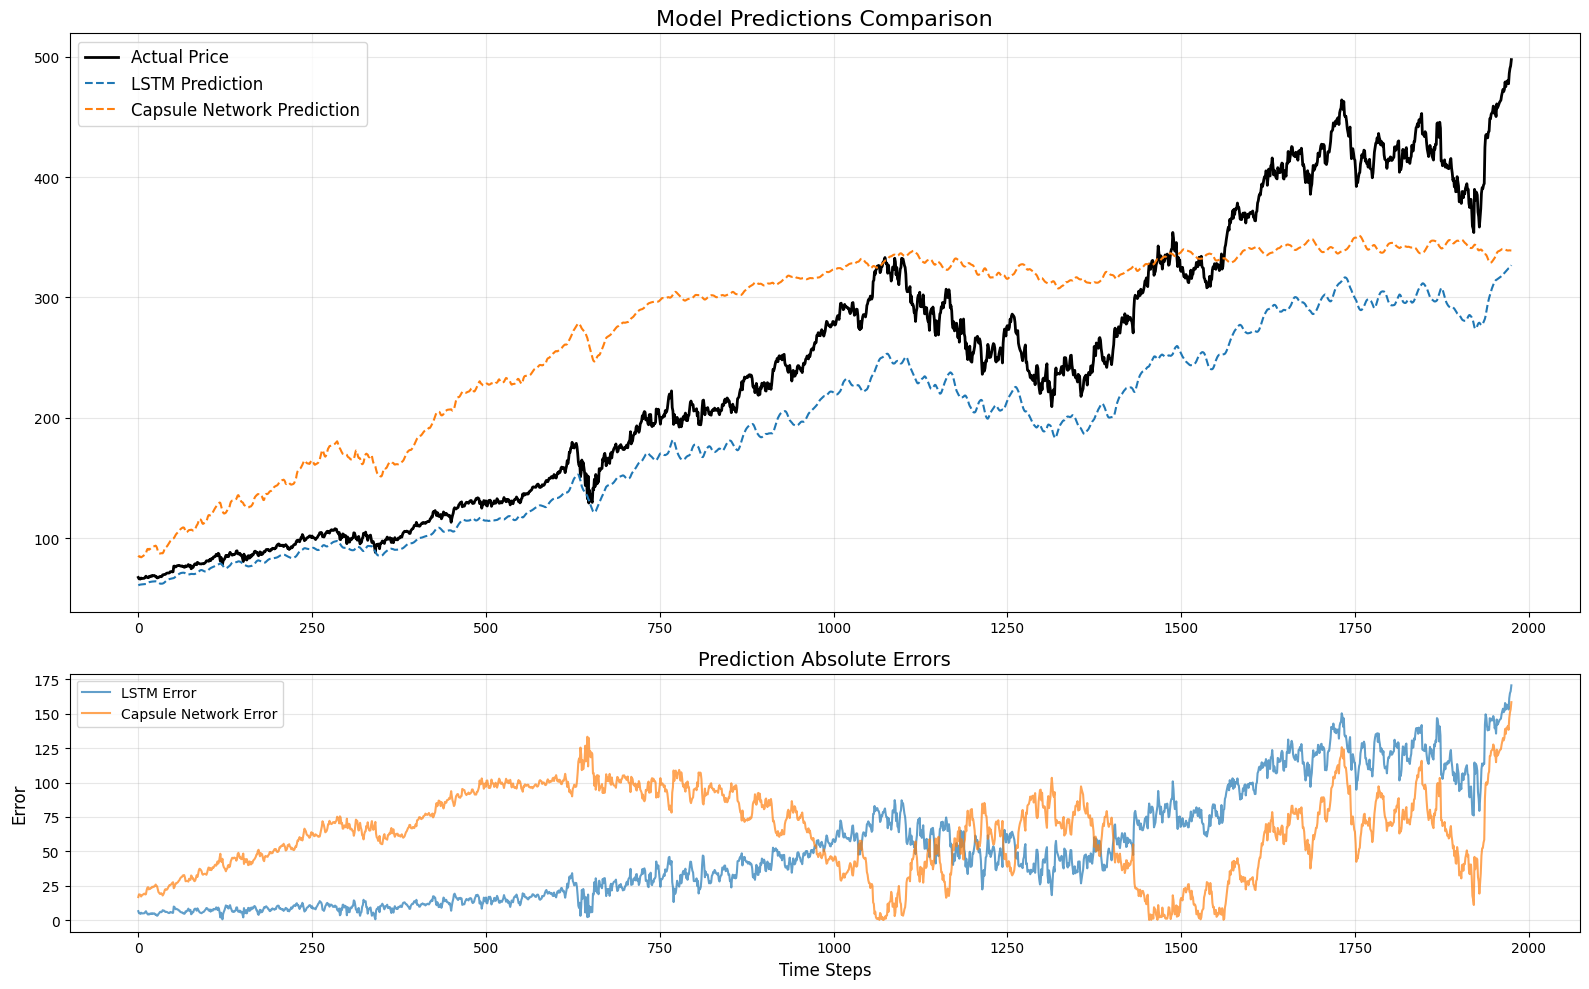

In [ ]:
def plot_comparison_with_error(models_dict, X_test, y_test, scaler):
    plt.figure(figsize=(16, 10))

    # Prepare actual prices
    dummy_array = np.zeros((len(y_test), 2))
    dummy_array[:, 0] = y_test.flatten()
    actual_prices = scaler.inverse_transform(dummy_array)[:, 0]

    # Create subplots
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    # Main plot (predictions)
    ax1.plot(actual_prices, label='Actual Price', color='black', linewidth=2)

    # Plot each model's predictions and store errors
    colors = ['#1f77b4', '#ff7f0e']  # Distinct colors
    errors = {}

    for i, (name, model) in enumerate(models_dict.items()):
        y_pred = model.predict(X_test)
        dummy_array[:, 0] = y_pred.flatten()
        y_pred_inv = scaler.inverse_transform(dummy_array)[:, 0]

        ax1.plot(y_pred_inv, label=f'{name} Prediction',
                color=colors[i], linestyle='--', linewidth=1.5)

        # Calculate absolute errors
        errors[name] = np.abs(y_pred_inv - actual_prices)

    ax1.set_title('Model Predictions Comparison', fontsize=16)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Error plot
    for i, (name, err) in enumerate(errors.items()):
        ax2.plot(err, color=colors[i], alpha=0.7, label=f'{name} Error')

    ax2.set_title('Prediction Absolute Errors', fontsize=14)
    ax2.set_xlabel('Time Steps', fontsize=12)
    ax2.set_ylabel('Error', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate enhanced plot
plot_comparison_with_error(models_to_compare, X_test, y_test, scaler)